#### WELFake Data Set
(WELFake) is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training. 

Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).

Dataset originally compiled by <a href="https://ieeexplore.ieee.org/document/9395133">P. K. Verma, P. Agrawal, I. Amorim and R. Prodan, "WELFake: Word Embedding Over Linguistic Features for Fake News Detection," in IEEE Transactions on Computational Social Systems, vol. 8, no. 4, pp. 881-893, Aug. 2021, doi: 10.1109/TCSS.2021.3068519.</a>


[1. Preliminary Data Description](#data_description)

[2. Prepare Input](#prepare_input)
- [2.1 Tokenization](#tokenization)
- [2.2 Pad sequences to fixed lenght](#sequences)

[3. Train and Evaluate](#train_evaluate)
- [3.1 Define the Model](#define_model)
- [3.2 Train the Model](#train_model)
- [3.3 Evaluate the Model](#evaluate_model)
    
[4. Conclusion](#conclusion) 
    

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.python.client import device_lib

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import collections

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
SEED = 42

In [3]:
df = pd.read_csv('../input/fake-news-classification/WELFake_Dataset.csv')
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']

X = df['text']
y = df['label']

<a id = 'data_description'></a>
## 1. Data Description

In [4]:
df['label'].value_counts()

1    36509
0    35028
Name: label, dtype: int64

In [5]:
df['label'].value_counts(normalize=True)

1    0.510351
0    0.489649
Name: label, dtype: float64

Let's see if fake news and real news are different in the length of the news article.

Text(0.5, 1.0, 'Distribution of the News Words count')

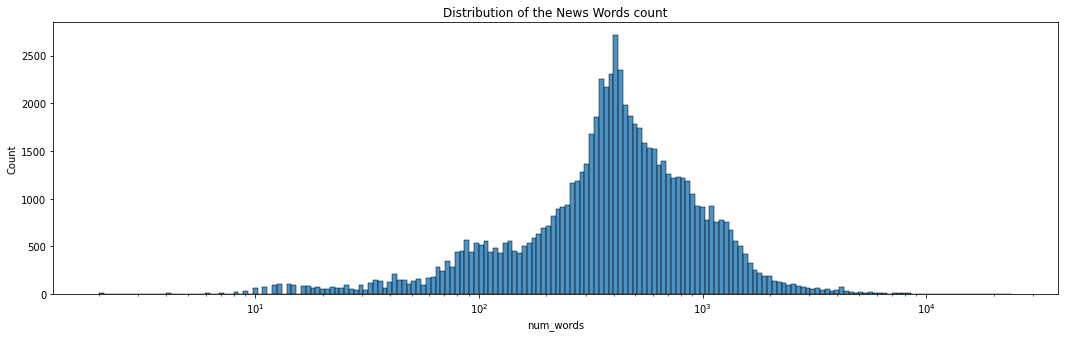

In [6]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize = (18,5))
sns.histplot(df['num_words'], palette = 'Set1', alpha = 0.8,log_scale=True)
plt.title('Distribution of the News Words count')

Text(0.5, 1.0, 'Distribution of the News Words count')

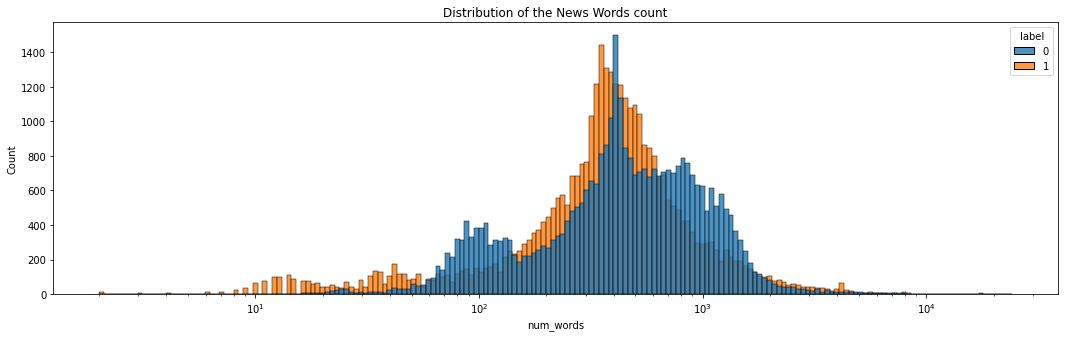

In [7]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize = (18,5))
sns.histplot(data=df,x='num_words',hue='label',alpha = 0.8, log_scale=True)
plt.title('Distribution of the News Words count')

The fake news are not very different from real news in their word counts. 

Let's explore if they use different words.

<AxesSubplot:xlabel='word', ylabel='count'>

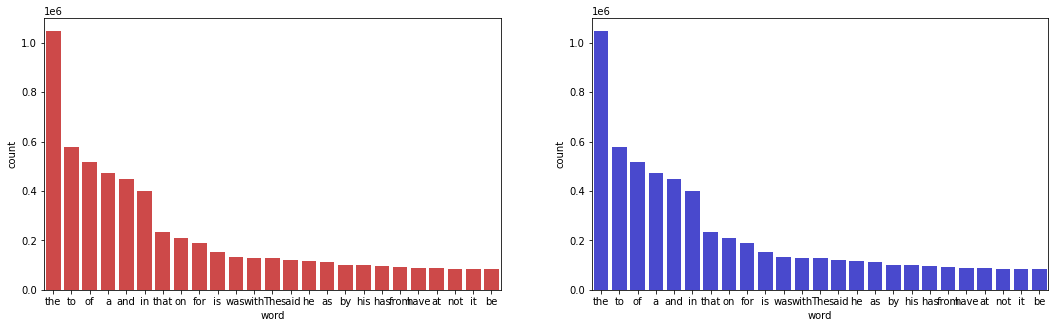

In [8]:
#get word collections for real/fake news
fake_news_words = collections.Counter([word for sentence in df[df['label'] == 0]['text'] for word in sentence.split()])
real_news_words = collections.Counter([word for sentence in df[df['label'] == 1]['text'] for word in sentence.split()])
df_mc_fake = pd.DataFrame(columns = ['word','count'], data=(fake_news_words.most_common(25)))
df_mc_real = pd.DataFrame(columns = ['word','count'], data=(fake_news_words.most_common(25)))

fig, axes = plt.subplots(1,2,figsize = (18, 5))
sns.barplot(data = df_mc_fake, x= 'word', y = 'count', color = '#dd0000', alpha = 0.8, ax = axes[0])
#axes[0].tickparams(axis = 'x', rotation = 90)
sns.barplot(data = df_mc_real, x= 'word', y = 'count', color = '#0000dd', alpha = 0.8, ax = axes[1])

The fake and real news do not seem to use different words, at least not captured in the most common 25 words.

Now we will use neural networks to detect the difference between the fake and real news. 

<a id = 'prepare_input'></a>
## 2. Preparing the input

In [9]:
#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = SEED)

<a id = 'tokenization'></a>
## 2.1 Tokenization 

In [10]:
#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

Train vocabulary size: 286000


<a id = 'sequences'></a>
## 2.2 Pad sequences to fixed lenght

In [11]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_LEN)

In [12]:
X_train_seq.shape[1]

512

<a id = 'train_evaluate'></a>
## 3. Train and evaluate two Keras models: CNN and LSTM

<a id = 'define_model1'></a>
## 3.1 Convolutional Neural Network (CNN) Model

<a id = 'define_model1'></a>
## 3.1.1 Define CNN Model

In [13]:
#define the model
model_cnn = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    tf.keras.layers.Conv1D(128,7,strides = 1),
    tf.keras.layers.Conv1D(64,7,strides = 1),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#compile model
model_cnn.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model_cnn.summary()

2023-01-15 03:07:55.434765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 03:07:55.530611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 03:07:55.531429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 128)          36608000  
_________________________________________________________________
conv1d (Conv1D)              (None, 506, 128)          114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           57408     
_________________________________________________________________
dense (Dense)                (None, 500, 64)           4160      
_________________________________________________________________
dropout (Dropout)            (None, 500, 64)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 500, 1)            65        
Total params: 36,784,449
Trainable params: 36,784,449
Non-trainable params: 0
____________________________________________

2023-01-15 03:07:55.533840: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 03:07:55.534259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 03:07:55.535395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 03:07:55.536453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

<a id = 'define_model1'></a>
## 3.1.2 Train CNN Model

In [14]:
history_cnn = model_cnn.fit(X_train_seq, y_train, epochs=5,
                    validation_split = 0.2, batch_size = 10, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

2023-01-15 03:07:58.267199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2023-01-15 03:08:00.400660: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4293/4293 [==============================] - 69s 14ms/step - loss: 0.5568 - accuracy: 0.6917 - val_loss: 0.5299 - val_accuracy: 0.7102
Epoch 2/5
4293/4293 [==============================] - 61s 14ms/step - loss: 0.5172 - accuracy: 0.7188 - val_loss: 0.5264 - val_accuracy: 0.7123
Epoch 3/5
4293/4293 [==============================] - 61s 14ms/step - loss: 0.5029 - accuracy: 0.7259 - val_loss: 0.5259 - val_accuracy: 0.7124
Epoch 4/5
4293/4293 [==============================] - 60s 14ms/step - loss: 0.4943 - accuracy: 0.7301 - val_loss: 0.5255 - val_accuracy: 0.7142
Epoch 5/5
4293/4293 [==============================] - 61s 14ms/step - loss: 0.4873 - accuracy: 0.7332 - val_loss: 0.5299 - val_accuracy: 0.7147


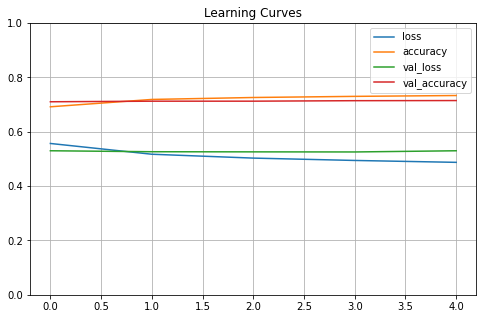

In [15]:
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning Curves')
plt.show()

<a id = 'evaluate_model1'></a>
## 3.1.3 Evaluate the CNN model

In [16]:
test_loss, test_acc = model_cnn.evaluate(X_test_seq, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

559/559 [==============================] - 2s 4ms/step - loss: 0.5317 - accuracy: 0.7104
Test Loss: 0.5317467451095581
Test Accuracy: 0.7103909254074097


<a id = 'model2'></a>
## 3.2 LSTM Model

<a id = 'define_model2'></a>
## 3.2.1 Define LSTM Model

In [17]:
#define the model
model_lstm = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#compile model
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 128)          36608000  
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 256)          263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 37,043,841
Trainable params: 37,043,841
Non-trainable params: 0
__________________________________________

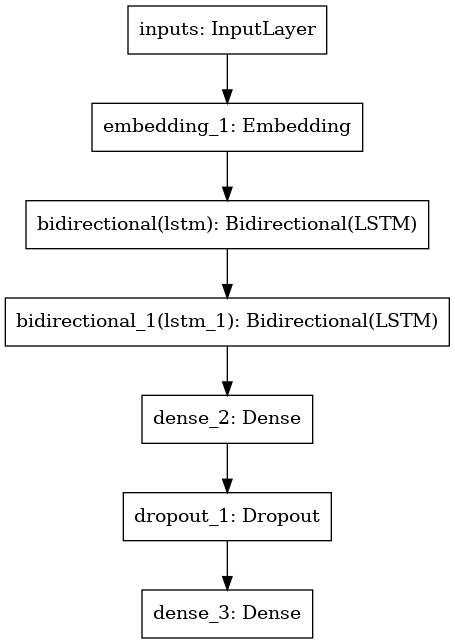

In [18]:
#plot the model architecture
tf.keras.utils.plot_model(model_lstm)

<a id = 'train_model2'></a>
## 3.2.2 Training the LSTM model

We will use a validation split of 20% during the training.

Early stopping based on max validation set accuracy.


In [19]:
history_lstm = model_lstm.fit(X_train_seq, y_train, epochs=10,
                    validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

Epoch 1/10
671/671 [==============================] - 93s 131ms/step - loss: 0.3433 - accuracy: 0.8462 - val_loss: 0.1682 - val_accuracy: 0.9329
Epoch 2/10
671/671 [==============================] - 87s 130ms/step - loss: 0.1166 - accuracy: 0.9596 - val_loss: 0.1175 - val_accuracy: 0.9557
Epoch 3/10
671/671 [==============================] - 86s 128ms/step - loss: 0.0502 - accuracy: 0.9856 - val_loss: 0.0919 - val_accuracy: 0.9709
Epoch 4/10
671/671 [==============================] - 86s 128ms/step - loss: 0.0205 - accuracy: 0.9949 - val_loss: 0.1277 - val_accuracy: 0.9630
Epoch 5/10
671/671 [==============================] - 87s 130ms/step - loss: 0.0112 - accuracy: 0.9973 - val_loss: 0.1338 - val_accuracy: 0.9656
Epoch 6/10
671/671 [==============================] - 87s 130ms/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 0.3062 - val_accuracy: 0.9278


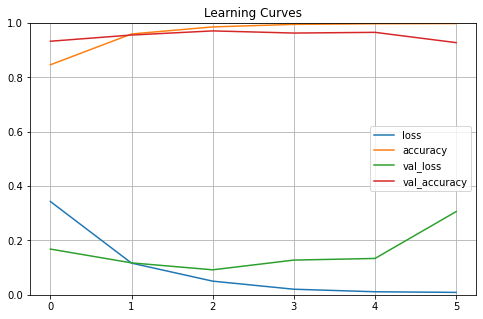

In [20]:
pd.DataFrame(history_lstm.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning Curves')
plt.show()

In [21]:
test_loss, test_acc = model_lstm.evaluate(X_test_seq, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

559/559 [==============================] - 20s 36ms/step - loss: 0.1012 - accuracy: 0.9691
Test Loss: 0.10121428966522217
Test Accuracy: 0.9690802097320557


<a id = 'evaluate_model2'></a>
## 3.2.3 Evaluate the LSTM model

<i><font size = 3.5>For final evaluation we use the separate test set</font></i>

In [22]:
## print classification report
y_hat = model_lstm.predict(X_test_seq)
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8757
           1       0.97      0.96      0.97      9128

    accuracy                           0.97     17885
   macro avg       0.97      0.97      0.97     17885
weighted avg       0.97      0.97      0.97     17885



Text(33.0, 0.5, 'Real Labels')

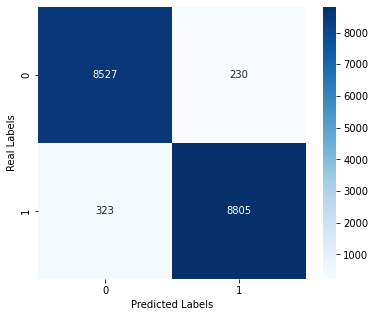

In [23]:
#plot the confusion matrix
plt.figure(figsize = (6,5))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

<a id = 'conclusion'></a>
## Conclusion
The sequencial neural networks model estimated using Keras has very high accuracy around 97%.